<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import scipy.linalg as la
import math
import random
import time
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import multiprocessing as mp
from multiprocessing import Pool
from functools import partial
import os
#############################
#fitting function
def fit_pAB(x,p,A,B):
    return A*p**x+B
def fit_pA(x,p,A):
    return A*p**x+0.5
###############################
'''def Nkron(*args):
	result = np.matrix('1.0')
	for item in args:
		result = np.kron(result,item)
	return result'''
'''def NormalizeState(State):
    return State/la.norm(State)'''
'''def seq_num(op):
    g = op[0]
    for i in range(1,len(op)):
        g = cliff_list[op[i]][g]
    return g'''
#############################
### find inverse w/ check ?= id
'''def _find_inverse_element(_sequence_list_length_by_1_)    
    _register = np.eye(2)
    for i in range(len(_sequence_list_length_by_1_)):
        _register  = cliff[_sequence_list_length_by_1_[i]]@_register
    print(_register) 
    for j in range(24):
        _x=cliff[j]@_register
        if (abs(_x[0][0]-_x[1][1])<10e-8 and abs(_x[1][0]-_x[0][1])<10e-8 and abs(_x[1][0])<10e-8):
            _sequence_list_length_by_1_.append(j)
    print(_sequence_list_length_by_1_)'''
### find inverse w/ inverse_index
def find_inverse_clifford_element(_sequence_list_length_by_1_):
    _register = _sequence_list_length_by_1_[0]
    for i in range(1,len(_sequence_list_length_by_1_)):
        _register  = cliff_list[_sequence_list_length_by_1_[i]][_register]
    _sequence_list_length_by_1_.append(inv_list[_register ])
    return _sequence_list_length_by_1_
#produce single types sequence and inverse
def sequence_list_length_by_1(_sequence_length):
    np.random.seed()
####random choose
    _sequence_list_length_by_1= list(np.random.randint(low=0, high=24, size=_sequence_length))
####add inverse element
    _sequence_list_length_by_1=find_inverse_clifford_element(_sequence_list_length_by_1)
    return _sequence_list_length_by_1
'''def irb_list(N,targ):
	op = []	
	for s in np.arange(0,N):
		op.append(random.randint(0,23))
		op.append(targ)
	n = seq_num(op)	
	op.append(inv_list[n])	
	return op'''
#############################
##sequence list (length X types)
def sequence_list_length_by_types(_experiment_type,_types,_i):
    _sequence_list_length_by_types = []
    if(_experiment_type==1):
        for i in range(_types):
            _sequence_list_length_by_types.append(sequence_list_length_by_1(_i))
    return _sequence_list_length_by_types
'''    elif(type==2):
        for i in range(_types):
            _sequence_element = irb_list(m,targ)
            _sequence_list.append(_sequence_element)
    return _sequence_list'''
def H(enable_x,enable_y,e_x,e_y,e_z):
    normalized_factor=np.sqrt((enable_x*(e_x+Omega))**2+(enable_y*(e_y+Omega))**2+e_z**2)    
    h={'h':enable_x*(e_x+Omega)*X+enable_y*(e_y+Omega)*Y+e_z*Z,
      'e_x':e_x,
      'e_y':e_y,
      'e_z':e_z,
      'normalized_factor':normalized_factor}
    return h
def U(_H,_angle):
    _time = _H['normalized_factor']*_angle/(2*Omega)
    H_=_H['h']/_H['normalized_factor']

    h={'h':np.eye(2)*np.cos(_time)-1j*np.sin(_time)*H_,
      'e_x':_H['e_x'],
      'e_y':_H['e_y'],
      'e_z':_H['e_z']}
    return h
####noisy primitive from H
def primitive(_primitive_index,e_x,e_y,e_z):
    if(_primitive_index==0):
        return U(H(0,0,e_x,e_y,e_z),0)
    if(_primitive_index==1):
        return U(H(1,0,e_x,e_y,e_z),pi)    # x-gate
    if(_primitive_index==2):
        return U(H(1,0,e_x,e_y,e_z),pi/2)  # x/2 
    if(_primitive_index==3):
        return U(H(-1,0,e_x,e_y,e_z),pi/2) # -x/2 
    if(_primitive_index==4):
        return U(H(0,1,e_x,e_y,e_z),pi)    # y
    if(_primitive_index==5):
        return U(H(0,1,e_x,e_y,e_z),pi/2)  # y/2
    if(_primitive_index==6):
        return U(H(-1,1,e_x,e_y,e_z),pi/2)  #- y/2
#combine noisy clifford element in primitive
###~p  ~p ~p ...
def noisy_cliff_ele(n):
    _noisy_cliff = np.eye(2)
    for primitive_index in cliff_decompose['C'+str(n)]:
        _h=primitive(primitive_index)
        _noisy_cliff = _h['h']@_noisy_cliff
    h={'h':_noisy_cliff,
      'e_x':_h['e_x'],
      'e_y':_h['e_y'],
      'e_z':_h['e_z']}
    return h

def primitive_gate_time(_primitive_index):
    if(_primitive_index==0):
        return 0/4/pi/Omega
    if(_primitive_index==1):
        return pi/4/pi/Omega    # x-gate
    if(_primitive_index==2):
        return pi/2/4/pi/Omega  # x/2 
    if(_primitive_index==3):
        return pi/2/4/pi/Omega # -x/2 
    if(_primitive_index==4):
        return pi/4/pi/Omega    # y
    if(_primitive_index==5):
        return pi/2/4/pi/Omega  # y/2
    if(_primitive_index==6):
        return pi/2/4/pi/Omega
#produce prob in same length
def sequence_to_probability(_sequence_length,_types,_repeat_index,_sequence):
    state =Zero
    _sequence_in_primitive=[]
    gate_time=0
    np.random.seed()
    e_x = np.random.normal(loc=0,scale=x_noise)
    e_y = np.random.normal(loc=0,scale=y_noise)
    e_z = np.random.normal(loc=0,scale=z_noise)
    for i in _sequence:
        for primitive_index in cliff_decompose['C'+str(i)]:
            _sequence_in_primitive.append(primitive_index)
            gate_time=gate_time+primitive_gate_time(primitive_index)
            if (gate_time>400e-6):
                gate_time=0
                
                np.random.seed()
                #####gaussian noise
                e_x = np.random.normal(loc=0,scale=x_noise)
                e_y = np.random.normal(loc=0,scale=y_noise)
                e_z = np.random.normal(loc=0,scale=z_noise)
            
            
            _h=primitive(primitive_index,e_x,e_y,e_z)
            state = _h['h']@state
    
    #_rho = np.outer(state,state)
    prob=abs(complex(state[0]))**2
    h={'sequence_length'+str(_sequence_length)+'types'+str(_types)+'repeat_index'+str(_repeat_index)+'probability':prob,
      'sequence_length'+str(_sequence_length)+'types'+str(_types)+'repeat_index'+str(_repeat_index)+'e_x':_h['e_x'],
      'sequence_length'+str(_sequence_length)+'types'+str(_types)+'repeat_index'+str(_repeat_index)+'e_y':_h['e_y'],
      'sequence_length'+str(_sequence_length)+'types'+str(_types)+'repeat_index'+str(_repeat_index)+'e_z':_h['e_z']}
    return h


In [ ]:
%timeit
if __name__ == '__main__':

    start_time = time.time()


    Zero = np.matrix('1;0')
    One = np.matrix('0;1')
###P0 zero state
###P1 one state
    P0 = np.dot(Zero,Zero.getH())
    P1 = np.dot(One,One.getH())

    pi = math.pi
###x, y ,z
    X = np.matrix('0 1; 1 0')
    Y = np.matrix('0 -1j; 1j 0')
    Z = np.matrix('1 0; 0 -1')
###data input
    cliff = np.load('cliff.npy')
    cliff_decompose = np.load('cliff_decompose.npy',allow_pickle=True).item()
    cliff_list = np.load('cliff_list.npy')
    inv_list = np.load('inv_list.npy')
    average_per_cliff=0
    for i in range(24):
        average_per_cliff= average_per_cliff+ len(cliff_decompose['C'+str(i)])

### sequence length m=[1,2,3,....]
    _sequence_length = int(input('paper(0), 10 gap(max m)\n'))
    if(_sequence_length==0):
        sequence_length=[1,2,3,4,5,6,8,10,13,16,20,25,32,40,50,63,79,100,126,158,200,251,316,398,501, 631, 794, 1000, 1259, 1585, 1995, 2512, 3162]
    else:
        sequence_length=[i for i in range(1,10)]+[i for i in range(11,_sequence_length,10)]
### different types in the same length m
    types = int(input('# types\n'))
### repeat in the same type, (average them )   
    _repeat = int(input('#  rep\n'))
    global repeat
    repeat=_repeat
###x , y, z noise    
    x_noise_ = float(input('x Noise Strength %\n'))
    global x_noise
    x_noise=x_noise_
    y_noise_ = float(input('y Noise Strength %\n'))
    global y_noise
    y_noise=y_noise_
    z_noise_ = float(input('z noise Detune (kHz) \n'))*1e3
    global z_noise
    z_noise=z_noise_
    global Omega
    Omega=285.7e3
    experiment_type = int(input('(1) Standard RB (2) Interleaved RB\n'))
    save = int(input('Save data (Y=1,N=0) \n'))	
    if(experiment_type==2):
        target_gate = int(input('Target Gate by clifford_index\n'))

    '''if(experiment_type==1):
        filename = 'data/rb_Ne'+str(N_e)+'_ratio'+str(ratio)+'_detune'+str(detune)+'.npy'
    if(experiment_type==2):
        filename = 'data/irb_targ'+str(targ)+'_Ne'+str(N_e)+'_ratio'+str(ratio)+'_detune'+str(detune)+'.npy'
    '''
    print('==================================')
    print(f'sequence_length {_sequence_length} ')
    print(f'type {types} ')
    print(f'repeat {repeat} ')
    print(f'x noise {x_noise} Hz')
    print(f'y noise {y_noise} Hz')
    print(f'Z noise {z_noise} Hz')
    print(f'average per cliff = {average_per_cliff/24} 個')
    print('==================================')
#######################################
###data output
    recover_probability = []
    recover_probability_error_bar = []
    data={}
#######################################    
    for i in sequence_length:
        _sequence_list_length_by_types = sequence_list_length_by_types(experiment_type,types,i)
        #print('whole seq=',_sequence_list_length_by_types)
        types_probability=[]
        m_average=[]
        for j in range(types):
            pool = mp.Pool()
    
            repeat_probability = pool.starmap(sequence_to_probability,[(i,j,d,e) for d in range(repeat) for e in [_sequence_list_length_by_types[j]]])
            #print(repeat_probability)
            pool.close()
            pool.join
            for k in repeat_probability:
                data.update(k)
        print(f'Finished (length {i})')
    print(f'Finished===================')
    '''prob['p'+str(i)] = result
        p.append(np.mean(result))
        err.append(np.std(result))'''
        
    '''else:
		p = []
		err = []
		for i in sequence_length:
			op_list = 
				#print(f'Finished (type {j})')
				result.append(seq_with_mp(op_list[j]))
				#print('res=',result)
			#prob['p'+str(i)] = np.mean(result)
			p.append(np.mean(result))
			err.append(np.std(result))
			print(f'Finished (length {i})')'''
    '''if(save=='y'):
        np.save(filename,prob)'''


paper(0), 10 gap(max m)
3000
# types
200
#  rep
200
x Noise Strength %
0
y Noise Strength %
0
z noise Detune (kHz) 
16.7
(1) Standard RB (2) Interleaved RB
1
Save data (Y=1,N=0) 
0
sequence_length 3000 
type 200 
repeat 200 
x noise 0.0 Hz
y noise 0.0 Hz
Z noise 16700.0 Hz
average per cliff = 1.875 個
Finished (length 1)
Finished (length 2)
Finished (length 3)
Finished (length 4)
Finished (length 5)
Finished (length 6)
Finished (length 7)
Finished (length 8)
Finished (length 9)
Finished (length 11)
Finished (length 21)
Finished (length 31)
Finished (length 41)
Finished (length 51)
Finished (length 61)
Finished (length 71)
Finished (length 81)
Finished (length 91)
Finished (length 101)
Finished (length 111)
Finished (length 121)
Finished (length 131)
Finished (length 141)
Finished (length 151)
Finished (length 161)
Finished (length 171)
Finished (length 181)
Finished (length 191)
Finished (length 201)
Finished (length 211)
Finished (length 221)
Finished (length 231)
Finished (length 241)

OLS Fit [r,p,A,B] 0.203 0.594 0.29 0.501
OLS & B=0.5 Fit [r,p,A] 0.199 0.602 0.288
WLS & B=0.5 Fit [r,p,A] 0.201 0.599 0.291


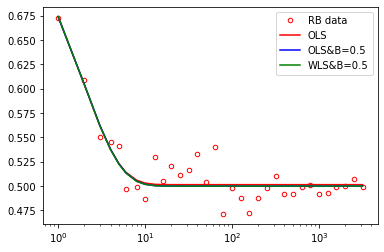

In [3]:
recover_probability=[]
recover_probability_error_bar=[]
for i in sequence_length:
    m_average=[]
    for j in range(types):
        m_t_average=[]
        for k in range(repeat):
            m_t_average.append(data['sequence_length'+str(i)+'types'+str(j)+'repeat_index'+str(k)+'probability'])
        data['sequence_length'+str(i)+'types'+str(j)+'average_probability']=np.mean(m_t_average)
        
        m_average.append(data['sequence_length'+str(i)+'types'+str(j)+'average_probability'])
        
    data['sequence_length'+str(i)+'average_probability']=np.mean(m_average)
    data['sequence_length'+str(i)+'std_probability']=np.std(m_average)
    recover_probability.append(data['sequence_length'+str(i)+'average_probability'])
    recover_probability_error_bar.append(data['sequence_length'+str(i)+'std_probability'])


mean, covar = curve_fit(fit_pAB,sequence_length,recover_probability,p0=[1,1,1],bounds=(0,1),maxfev=10000)
print('OLS Fit [r,p,A,B]','%.3g' % ((1-mean[0])*0.5),'%.3g' % mean[0],'%.3g' % mean[1],'%.3g' % mean[2])
mean1, covar1 = curve_fit(fit_pA,sequence_length,recover_probability,p0=[1,1],bounds=(0,1),maxfev=10000)
print('OLS & B=0.5 Fit [r,p,A]','%.3g' % ((1-mean1[0])*0.5),'%.3g' % mean1[0],'%.3g' % mean1[1])
mean2, covar2 = curve_fit(fit_pA,sequence_length,recover_probability,p0=[1,1],sigma=recover_probability_error_bar,absolute_sigma = True,bounds=(0,1))
print('WLS & B=0.5 Fit [r,p,A]','%.3g' % ((1-mean2[0])*0.5),'%.3g' % mean2[0],'%.3g' % mean2[1])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sequence_length,recover_probability,'.',color='r',markerfacecolor='none',markersize=9,label='RB data')
ax.plot(sequence_length,fit_pAB(sequence_length, *mean),'-',color='r',label='OLS')
ax.plot(sequence_length,fit_pA(sequence_length, *mean1),'-',color='b',label='OLS&B=0.5')
ax.plot(sequence_length,fit_pA(sequence_length, *mean2),'-',color='g',label='WLS&B=0.5')
#ax.errorbar(sequence_length,recover_probability,color='r',yerr=recover_probability_error_bar,capsize=8,fmt=' ')	
ax.set_xscale('log')
ax.legend(loc='best')
plt.savefig("RB.png")
plt.show()

In [ ]:
print(recover_probability)

In [ ]:
da=[]
for i in range(3):
    for primitive_index in cliff_decompose['C'+str(i)]:
        da.append(primitive_index)
print(da)